In [1]:
#!pip install yahoo-historical
#!pip install empyrical

# Imports

In [2]:
#imports
from yahoo_historical import Fetcher
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import empyrical
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# Data

In [3]:
#Fetching data
begin_fetch_date=[2017,1,1]
df_sp=Fetcher('SPY',begin_fetch_date).get_historical()
df_xlk=Fetcher('XLK',begin_fetch_date).get_historical()
df_xle=Fetcher('XLE',begin_fetch_date).get_historical()
df_xlf=Fetcher('XLF',begin_fetch_date).get_historical()

In [4]:
#dataframe
data=pd.DataFrame(columns=['1W_sp', '2W_sp', '1M_sp','2M_sp',
                           '1W_xlk', '2W_xlk', '1M_xlk','2M_xlk',
                           '1W_xle', '2W_xle', '1M_xle','2M_xle',
                           '1W_xlf', '2W_xlf', '1M_xlf','2M_xlf'])


#Previous Log returns
price_column='Close'

data.loc[:,'1W_sp']=np.log1p(df_sp[price_column].pct_change(5))
data['2W_sp']=np.log1p(df_sp[price_column].pct_change(10))
data['1M_sp']=np.log1p(df_sp[price_column].pct_change(20))
data['2M_sp']=np.log1p(df_sp[price_column].pct_change(50))

data['1W_xlk']=np.log1p(df_xlk[price_column].pct_change(5))
data['2W_xlk']=np.log1p(df_xlk[price_column].pct_change(10))
data['1M_xlk']=np.log1p(df_xlk[price_column].pct_change(20))
data['2M_xlk']=np.log1p(df_xlk[price_column].pct_change(50))

data['1W_xle']=np.log1p(df_xle[price_column].pct_change(5))
data['2W_xle']=np.log1p(df_xle[price_column].pct_change(10))
data['1M_xle']=np.log1p(df_xle[price_column].pct_change(20))
data['2M_xle']=np.log1p(df_xle[price_column].pct_change(50))

data['1W_xlf']=np.log1p(df_xlf[price_column].pct_change(5))
data['2W_xlf']=np.log1p(df_xlf[price_column].pct_change(10))
data['1M_xlf']=np.log1p(df_xlf[price_column].pct_change(20))
data['2M_xlf']=np.log1p(df_xlf[price_column].pct_change(50))

#Next log and raw returns

data['next_log_return_sp']=np.log1p(df_sp[price_column].pct_change(1)).shift(-1)

data['next_raw_return']=df_sp[price_column].pct_change(1).shift(-1)

#Addinfg dates
data['next_date']=pd.to_datetime(df_sp['Date'].shift(-1)).values

data['date']=pd.to_datetime(df_sp['Date']).values

data.index=pd.to_datetime(df_sp.Date)

#Remove the 50 first days and the last day
data=data.iloc[50:-1]

#Re-adjust
data=data.iloc[data.shape[0]%120:]


In [5]:
data.head()

,1W_sp,2W_sp,1M_sp,2M_sp,1W_xlk,2W_xlk,1M_xlk,2M_xlk,1W_xle,2W_xle,1M_xle,2M_xle,1W_xlf,2W_xlf,1M_xlf,2M_xlf,next_log_return_sp,next_raw_return,next_date,date
Date,,,,,,,,,,,,,,,,,,,,
2017-05-19,-0.002808,-0.005816,0.015733,0.006103,-0.005776,0.004900,0.038193,0.044608,0.004859,0.011375,0.004269,-0.029382,-0.008953,-0.020768,0.008170,-0.060650,0.005065,0.005077,2017-05-22,2017-05-19
2017-05-22,-0.003251,-0.000584,0.009860,0.007670,-0.003407,0.008477,0.034348,0.047256,-0.005139,0.002063,-0.003820,-0.030160,-0.013998,-0.017362,-0.011468,-0.057277,0.002210,0.002213,2017-05-23,2017-05-22
2017-05-23,-0.000125,0.002544,0.006268,0.009375,-0.006255,0.009004,0.030951,0.048109,0.002205,0.012711,-0.009937,-0.027951,-0.009283,-0.005917,-0.012637,-0.052035,0.002330,0.002333,2017-05-24,2017-05-23
2017-05-24,0.020109,0.003080,0.009227,0.015539,0.025496,0.009327,0.036176,0.054484,0.006815,-0.005742,-0.011888,-0.021905,0.022299,-0.009707,-0.012224,-0.049638,0.004768,0.004779,2017-05-25,2017-05-24
2017-05-25,0.020856,0.009893,0.013157,0.011691,0.026769,0.017706,0.039228,0.054836,-0.011215,-0.022012,-0.019213,-0.062233,0.020099,-0.001692,-0.005910,-0.046328,-0.000207,-0.000207,2017-05-26,2017-05-25


# Creating models and Backtesting

### init output tables

In [6]:
#Init results table
positions=pd.DataFrame(columns=['OLS','Lasso','EN','Ridge','kNN','date','next_date','real_next_returns'])

OLS_positions=np.array([])
Lasso_positions=np.array([])
Ridge_positions=np.array([])
kNN_positions=np.array([])
EN_positions=np.array([])
date=np.array([],dtype=np.datetime64)
next_date=np.array([],dtype=np.datetime64)
real_next_returns=np.array([])

#Init logs table
log=pd.DataFrame(columns=['period','model','best_params','coef'])

### simulation

In [7]:
#Simulation
for k in range(0,len(data)-100,20): #recalibrate every 20 days
    
    ####################Data preparation###########################
    data_k=data.iloc[k:k+120] #select 100 days dor training and 20 for prediction
    
    #train and test split
    X_train, y_train = data_k[['1W_sp', '2W_sp', '1M_sp','2M_sp',
                               '1W_xlk', '2W_xlk', '1M_xlk','2M_xlk',
                               '1W_xle', '2W_xle', '1M_xle','2M_xle',
                               '1W_xlf', '2W_xlf', '1M_xlf','2M_xlf']].iloc[-120:-20].values , data_k['next_log_return_sp'].iloc[-120:-20].values 

    X_test, y_test = data_k[['1W_sp', '2W_sp', '1M_sp','2M_sp',
                               '1W_xlk', '2W_xlk', '1M_xlk','2M_xlk',
                               '1W_xle', '2W_xle', '1M_xle','2M_xle',
                               '1W_xlf', '2W_xlf', '1M_xlf','2M_xlf']].iloc[-20:].values, data_k['next_log_return_sp'].iloc[-20:].values

    
    real_next_returns_k =  data_k['next_raw_return'].iloc[-20:].values

    next_date_k =  data_k['next_date'].iloc[-20:].values
    
    date_k =  data_k['date'].iloc[-20:].values
    
    date=np.concatenate([date,date_k],axis=0)
    next_date=np.concatenate([next_date,next_date_k],axis=0)
    real_next_returns=np.concatenate([real_next_returns,real_next_returns_k],axis=0)

    #scaling
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.fit_transform(X_test)
    
    ####################OLS###########################
    ols=linear_model.LinearRegression()
    ols.fit(X_train,y_train)
    y_pred=ols.predict(X_test)
    
    position=(y_pred>0).astype(int)
    position[position==0]=-1
    
    OLS_positions=np.concatenate([OLS_positions,position],axis=0)
    
    log=log.append({'period':date_k[0], 'model':'OLS', 'best_params':ols.get_params(), 'coef':ols.coef_},ignore_index=True)
    
    ####################Lasso###########################
    lasso_params = {'alpha':np.linspace(0.001,0.05,100)}
    #lasso_params = {'alpha':[0.001]}

    tscv = TimeSeriesSplit(n_splits=3)
    lasso=GridSearchCV(linear_model.Lasso(),param_grid=lasso_params,cv=tscv,refit=True).fit(X_train, y_train).best_estimator_

    y_pred=lasso.predict(X_test)
    
    position=(y_pred>0).astype(int)
    position[position==0]=-1
    
    Lasso_positions=np.concatenate([Lasso_positions,position],axis=0)
    
    log=log.append({'period':date_k[0], 'model':'Lasso', 'best_params':lasso.get_params(), 'coef':lasso.coef_},ignore_index=True)

    
    ####################Ridge###########################
    ridge_params = {'alpha':np.linspace(0.001,10,100)}

    tscv = TimeSeriesSplit(n_splits=3)
    ridge=GridSearchCV(linear_model.Ridge(),param_grid=ridge_params,cv=tscv,refit=True).fit(X_train, y_train).best_estimator_

    y_pred=ridge.predict(X_test)

    position=(y_pred>0).astype(int)
    position[position==0]=-1

    Ridge_positions=np.concatenate([Ridge_positions,position],axis=0)
    
    log=log.append({'period':date_k[0], 'model':'ridge', 'best_params':ridge.get_params(), 'coef':ridge.coef_},ignore_index=True)
    
    ####################Elastic Net###########################
    en_params = {'alpha':np.linspace(0.001,10,100),
                'l1_ratio':np.linspace(0.1,0.9,9)}

    tscv = TimeSeriesSplit(n_splits=3)
    en=GridSearchCV(linear_model.ElasticNet(max_iter=10000),param_grid=en_params,cv=tscv,refit=True).fit(X_train, y_train).best_estimator_

    y_pred=en.predict(X_test)

    position=(y_pred>0).astype(int)
    position[position==0]=-1

    EN_positions=np.concatenate([EN_positions,position],axis=0)
    
    log=log.append({'period':date_k[0], 'model':'EN', 'best_params':en.get_params(), 'coef':en.coef_},ignore_index=True)
    
    ####################kNN Regression###########################
    knn_params = {'weights' : ['uniform', 'distance'],
                 'n_neighbors': list(range(1,10))}

    tscv = TimeSeriesSplit(n_splits=3)
    knn=GridSearchCV(KNeighborsRegressor(),param_grid=knn_params,cv=tscv,refit=True).fit(X_train, y_train).best_estimator_

    y_pred=knn.predict(X_test)
    
    position=(y_pred>0).astype(int)
    position[position==0]=-1
    
    kNN_positions=np.concatenate([kNN_positions,position],axis=0)
    
    log=log.append({'period':date_k[0], 'model':'kNN', 'best_params':knn.get_params()},ignore_index=True)

    

In [8]:
positions['OLS']=OLS_positions
positions['Ridge']=Ridge_positions
positions['Lasso']=Lasso_positions
positions['kNN']=kNN_positions
positions['EN']=EN_positions

positions['date']=date
positions['next_date']=next_date
positions['real_next_returns']=real_next_returns

In [9]:
positions

,OLS,Lasso,EN,Ridge,kNN,date,next_date,real_next_returns
0,1.0,1.0,1.0,1.0,1.0,2017-10-11,2017-10-12,-0.001490
1,1.0,1.0,1.0,1.0,1.0,2017-10-12,2017-10-13,0.001217
2,1.0,1.0,1.0,1.0,1.0,2017-10-13,2017-10-16,0.001334
3,1.0,1.0,1.0,1.0,1.0,2017-10-16,2017-10-17,0.000705
4,1.0,1.0,1.0,1.0,1.0,2017-10-17,2017-10-18,0.000979
...,...,...,...,...,...,...,...,...
855,1.0,1.0,1.0,1.0,1.0,2021-03-08,2021-03-09,0.014278
856,1.0,1.0,1.0,1.0,1.0,2021-03-09,2021-03-10,0.006225
857,1.0,1.0,1.0,1.0,1.0,2021-03-10,2021-03-11,0.010139
858,1.0,1.0,1.0,1.0,-1.0,2021-03-11,2021-03-12,0.001347


# PnL plots, Analysis 

### Calculate cumualtive returns and Sharpe Ratio

In [10]:
###################Long###########################
cumulative_returns_long=empyrical.cum_returns(positions['real_next_returns'], starting_value=1)

SR_long=empyrical.sharpe_ratio(positions['real_next_returns'])

###################OLS###########################
cumulative_returns_ols=empyrical.cum_returns(positions['OLS'].values*positions['real_next_returns'], 
                                             starting_value=1)

SR_ols=empyrical.sharpe_ratio(positions['OLS'].values*positions['real_next_returns'])

###################Ridge###########################
cumulative_returns_ridge=empyrical.cum_returns(positions['Ridge'].values*positions['real_next_returns'],
                                               starting_value=1)

SR_ridge=empyrical.sharpe_ratio(positions['Ridge'].values*positions['real_next_returns'])

###################Lasso###########################
cumulative_returns_lasso=empyrical.cum_returns(positions['Lasso'].values*positions['real_next_returns'], 
                                               starting_value=1)

SR_lasso=empyrical.sharpe_ratio(positions['Lasso'].values*positions['real_next_returns'])

###################Elastic Net###########################
cumulative_returns_en=empyrical.cum_returns(positions['EN'].values*positions['real_next_returns'], 
                                               starting_value=1)

SR_en=empyrical.sharpe_ratio(positions['EN'].values*positions['real_next_returns'])

###################kNN###########################
cumulative_returns_knn=empyrical.cum_returns(positions['kNN'].values*positions['real_next_returns'], 
                                             starting_value=1)

SR_knn=empyrical.sharpe_ratio(positions['kNN'].values*positions['real_next_returns'])


### Plot results

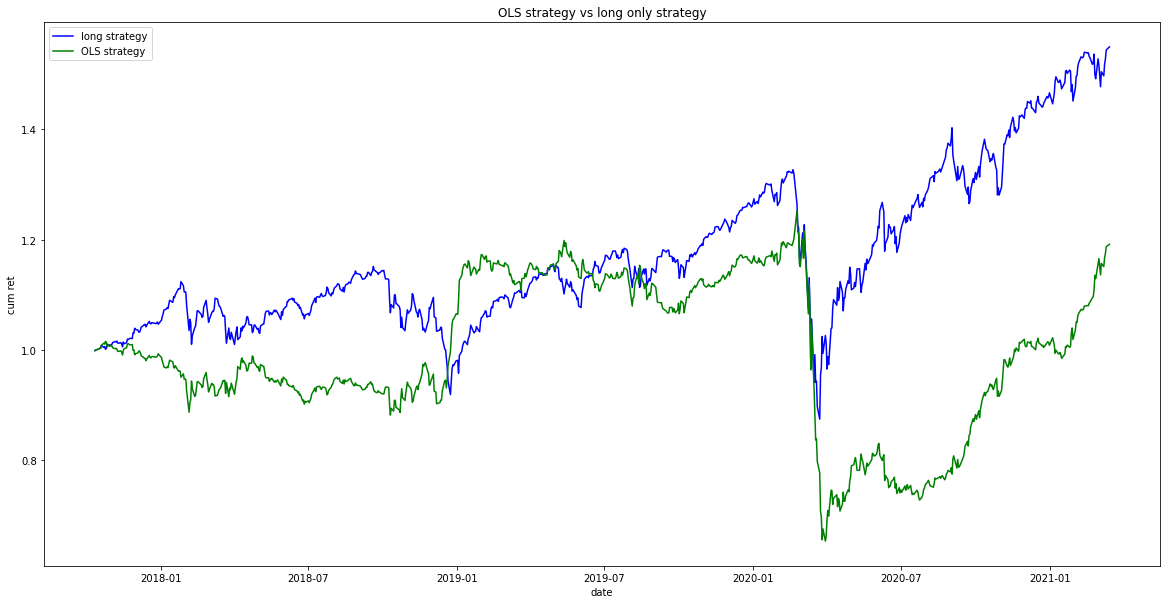

In [11]:
plt.plot(positions.next_date.values,cumulative_returns_long, color='b', label='long strategy')
plt.plot(positions.next_date.values,cumulative_returns_ols, color='g', label='OLS strategy')
plt.title('OLS strategy vs long only strategy')
plt.legend()
plt.xlabel('date')
plt.ylabel('cum ret')
plt.show()

In [12]:
print('The %s method made a SR of %s and the long only strategy made a SR of %s' % ('OLS' ,str(SR_ols) ,str(SR_long)))

The OLS method made a SR of 0.34516240428092076 and the long only strategy made a SR of 0.6965802017366504


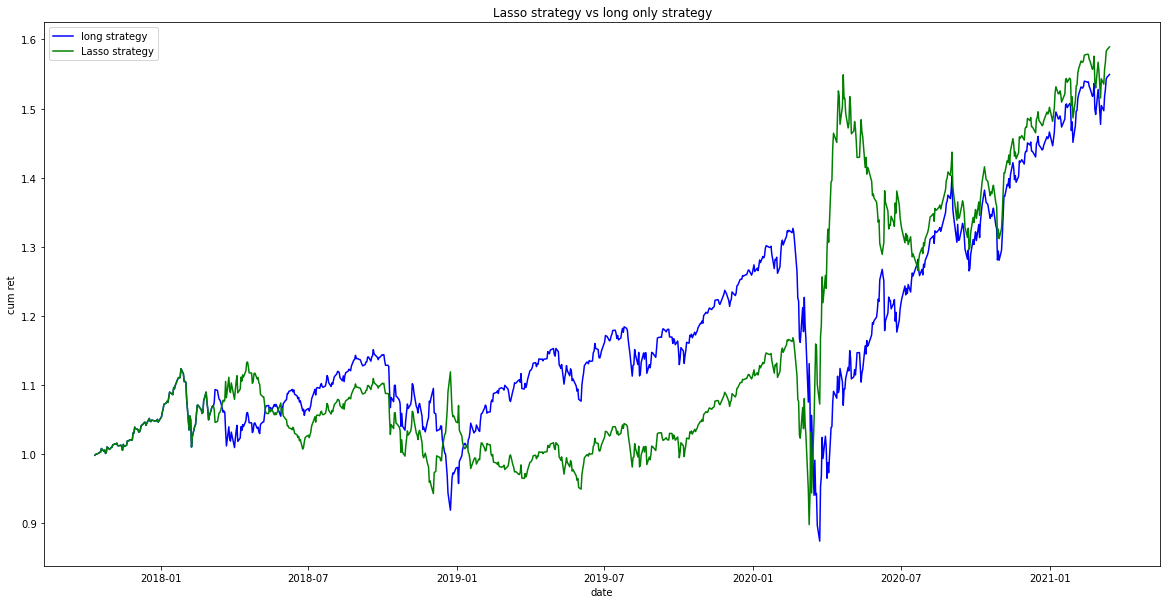

In [13]:

plt.plot(positions.next_date.values,cumulative_returns_long, color='b', label='long strategy')
plt.plot(positions.next_date.values,cumulative_returns_lasso, color='g', label='Lasso strategy')
plt.title('Lasso strategy vs long only strategy')
plt.legend()
plt.xlabel('date')
plt.ylabel('cum ret')
plt.show()

In [14]:
print('The %s method made a SR of %s and the long only strategy made a SR of %s' % ('Lasso' ,str(SR_lasso) ,str(SR_long)))

The Lasso method made a SR of 0.7290286853486808 and the long only strategy made a SR of 0.6965802017366504


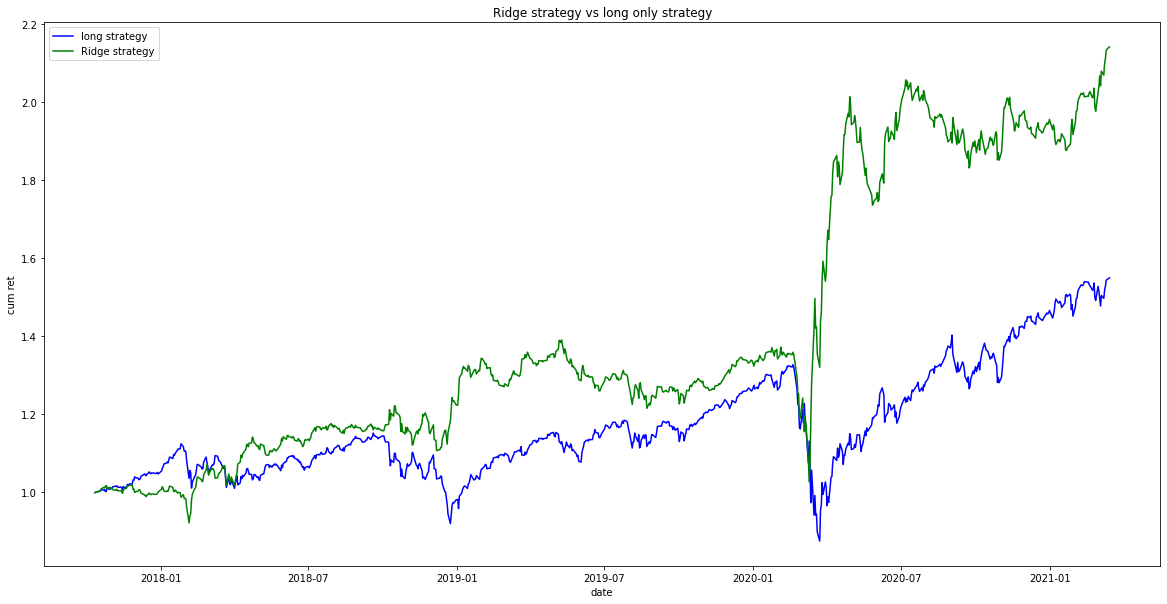

In [15]:
plt.plot(positions.next_date.values,cumulative_returns_long, color='b', label='long strategy')
plt.plot(positions.next_date.values,cumulative_returns_ridge, color='g', label='Ridge strategy')
plt.title('Ridge strategy vs long only strategy')
plt.legend()
plt.xlabel('date')
plt.ylabel('cum ret')
plt.show()

In [16]:
print('The %s method made a SR of %s and the long only strategy made a SR of %s' % ('Ridge' ,str(SR_ridge) ,str(SR_long)))

The Ridge method made a SR of 1.1297054853396793 and the long only strategy made a SR of 0.6965802017366504


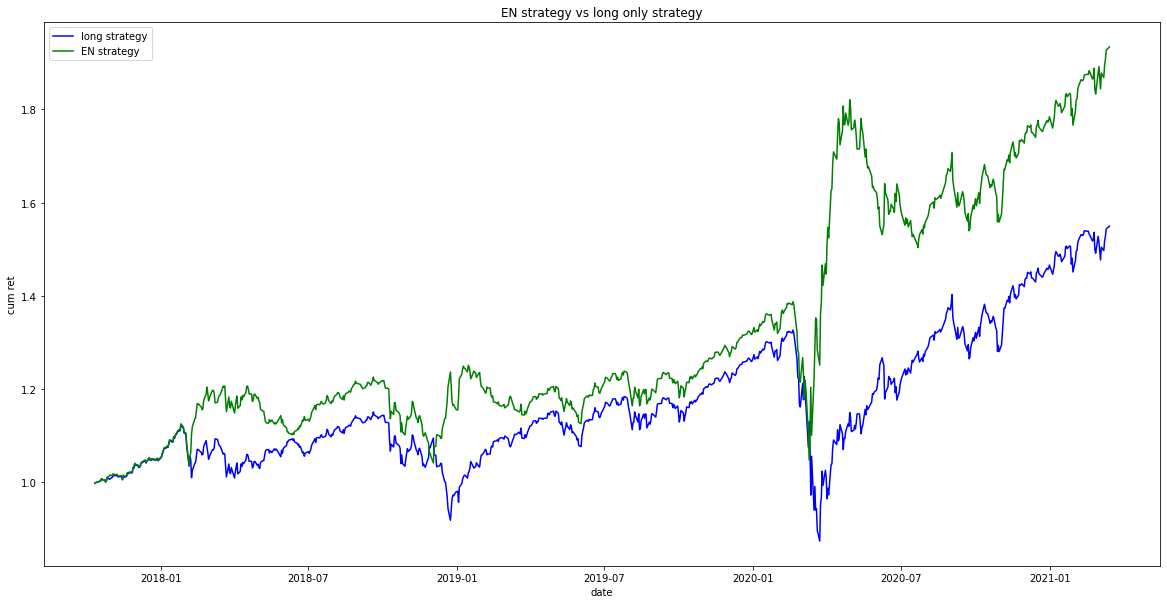

In [17]:
plt.plot(positions.next_date.values,cumulative_returns_long, color='b', label='long strategy')
plt.plot(positions.next_date.values,cumulative_returns_en, color='g', label='EN strategy')
plt.title('EN strategy vs long only strategy')
plt.legend()
plt.xlabel('date')
plt.ylabel('cum ret')
plt.show()

In [18]:
print('The %s method a SR of %s and the long only strategy made a SR of %s' % ('Elastic Net' ,str(SR_en) ,str(SR_long)))

The Elastic Net method a SR of 0.9927308505352564 and the long only strategy made a SR of 0.6965802017366504


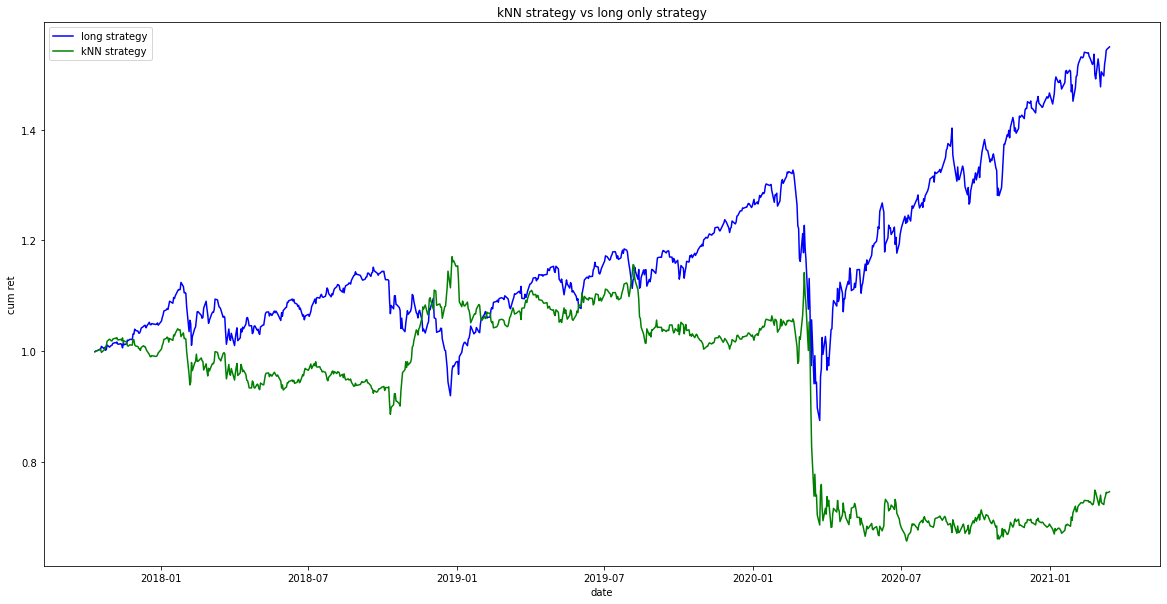

In [19]:
plt.plot(positions.next_date.values,cumulative_returns_long, color='b', label='long strategy')
plt.plot(positions.next_date.values,cumulative_returns_knn, color='g', label='kNN strategy')
plt.title('kNN strategy vs long only strategy')
plt.legend()
plt.xlabel('date')
plt.ylabel('cum ret')
plt.show()

In [20]:
print('The %s method made a SR of %s and the long only strategy made a SR of %s' % ('kNN' ,str(SR_knn) ,str(SR_long)))

The kNN method made a SR of -0.2823714822788036 and the long only strategy made a SR of 0.6965802017366504


### Analysis

### 1. OLS

The strategy resulted from the OLS model has yielded a cumulative return and sharpe ratio lower than the long only strategy. The OLS model has no regularization. That's why it tries to find the weights for every feature without taking into account curve fitting due to feature random significance or the value of the weights that can go out of proportion in some cases.
Here is the evolution of the each variable coefficient over the backtesting period.

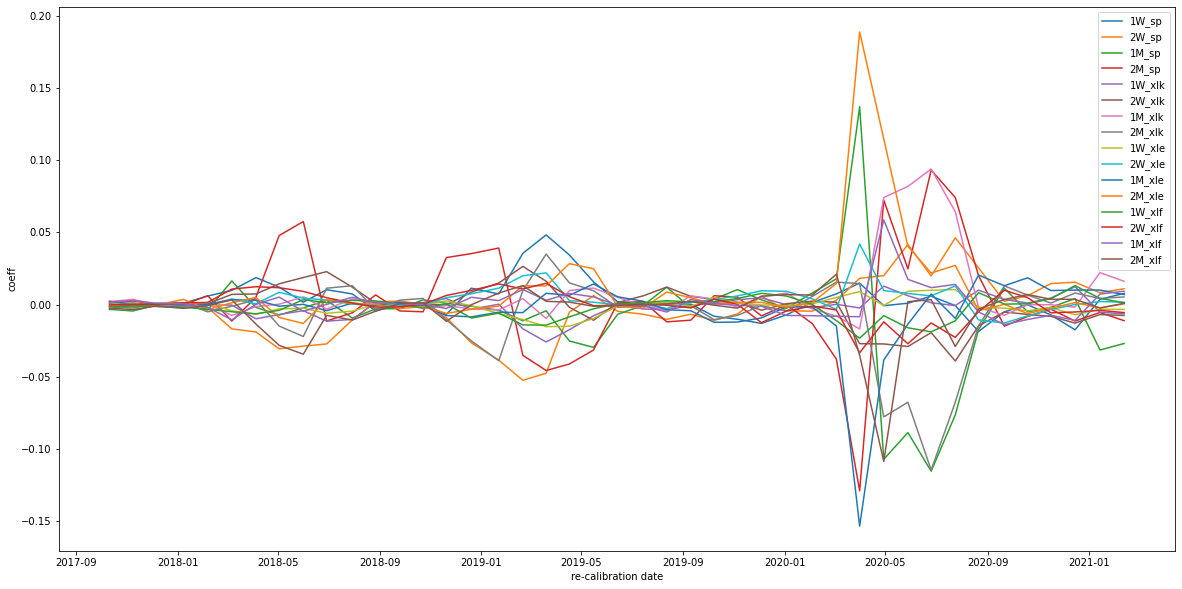

In [21]:
coef=np.concatenate(log[log.model=='OLS'].coef.values,axis=0).reshape(43,16)
features=data.columns[:16]
calibration_date=log.period.unique()
for i in range(16): 
    plt.plot(calibration_date,coef[:,i],label=features[i])  
plt.legend()
plt.xlabel('re-calibration date')
plt.ylabel('coeff')
plt.show()

We can see that in some cases, weights of 2W_sp, 1M,sp, 2M_sp and 1M_xlk can have big values relatively to other weights.

### 2. Lasso

The strategy resulted from the Lasso model has yielded a cumulative return and sharpe ratio higher than the long only strategy but the difference was not much we can see that Lasso had a rough start during the first part of the backtesting period.

The Lasso model is a Linear Model trained with L1 prior as regularizer.

The goal of lasso regression is to obtain the subset of predictors that minimizes prediction error for a quantitative response variable. The lasso does this by imposing a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero.

Here is the evolution of the each variable coefficient over the backtesting period and the evolution of the best alpha value resulted from the cross validation.

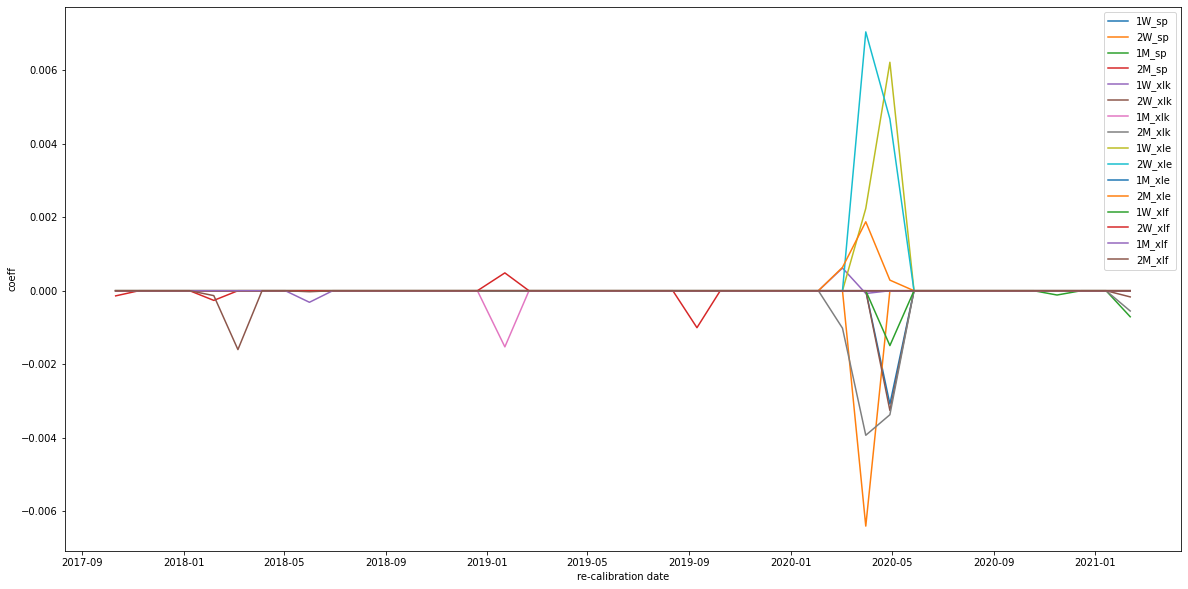

In [22]:
coef=np.concatenate(log[log.model=='Lasso'].coef.values,axis=0).reshape(43,16)
features=data.columns[:16]
calibration_date=log.period.unique()
for i in range(16): 
    plt.plot(calibration_date,coef[:,i],label=features[i])  
plt.legend()
plt.xlabel('re-calibration date')
plt.ylabel('coeff')
plt.show()

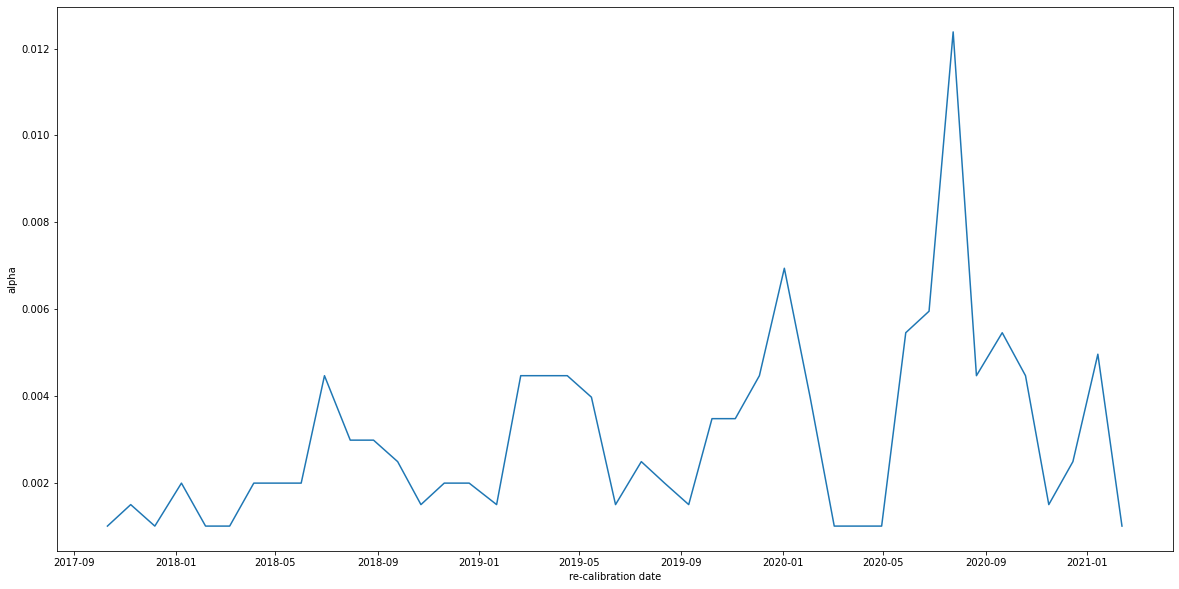

In [23]:
alpha=log[log.model=='Lasso'].best_params.apply(lambda x : x['alpha']).values
calibration_date=log.period.unique()
plt.plot(calibration_date,alpha)  
plt.xlabel('re-calibration date')
plt.ylabel('alpha')
plt.show()

We can see that according to the cross validation at every re-calibartion, few predictors have non null weghts.

### 3. Ridge

The strategy resulted from the Ridge model has yielded a cumulative return and sharpe ratio higher than the long only strategy and has clearly outperformed the first strategy in the part of the backtesting period (after the covid crisis)

The Ridge model is a Linear Model trained with L2 prior as regularizer.

Ridge regression is a special case of Tikhonov regularization in which all parameters are regularized equally. Ridge regression is particularly useful to mitigate the problem of multicollinearity in linear regression

Here is the evolution of the each variable coefficient over the backtesting period and the evolution of the best alpha value resulted from the cross validation.

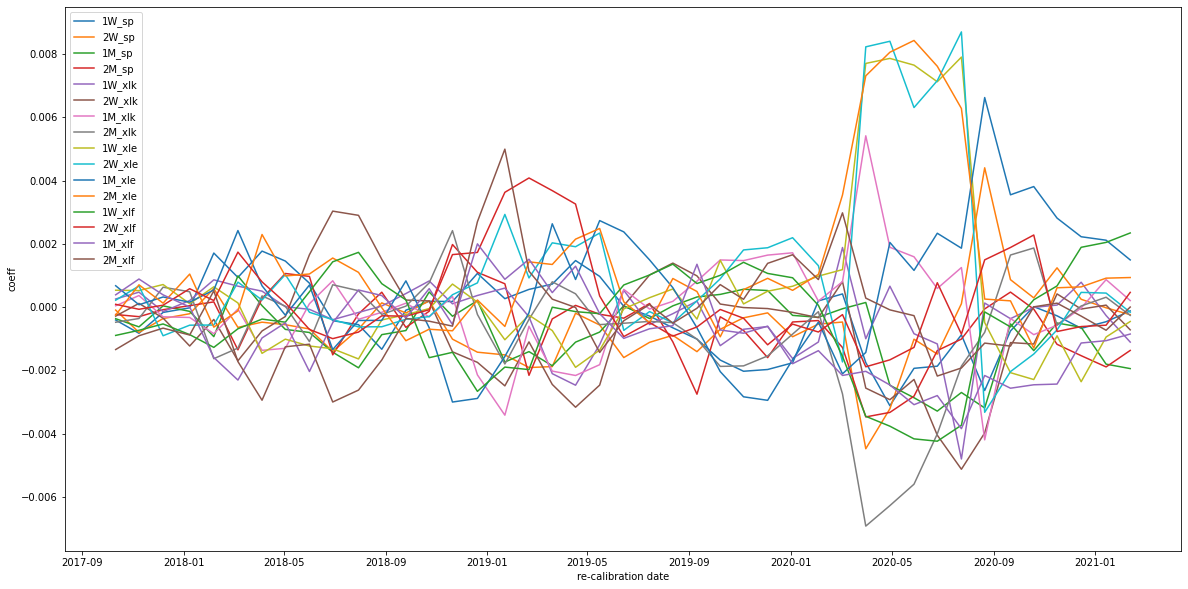

In [24]:
coef=np.concatenate(log[log.model=='ridge'].coef.values,axis=0).reshape(43,16)
features=data.columns[:16]
calibration_date=log.period.unique()
for i in range(16): 
    plt.plot(calibration_date,coef[:,i],label=features[i])  
plt.legend()
plt.xlabel('re-calibration date')
plt.ylabel('coeff')
plt.show()

We can see that the value of the coefficients is lower and limited in comparison to the OLS model.

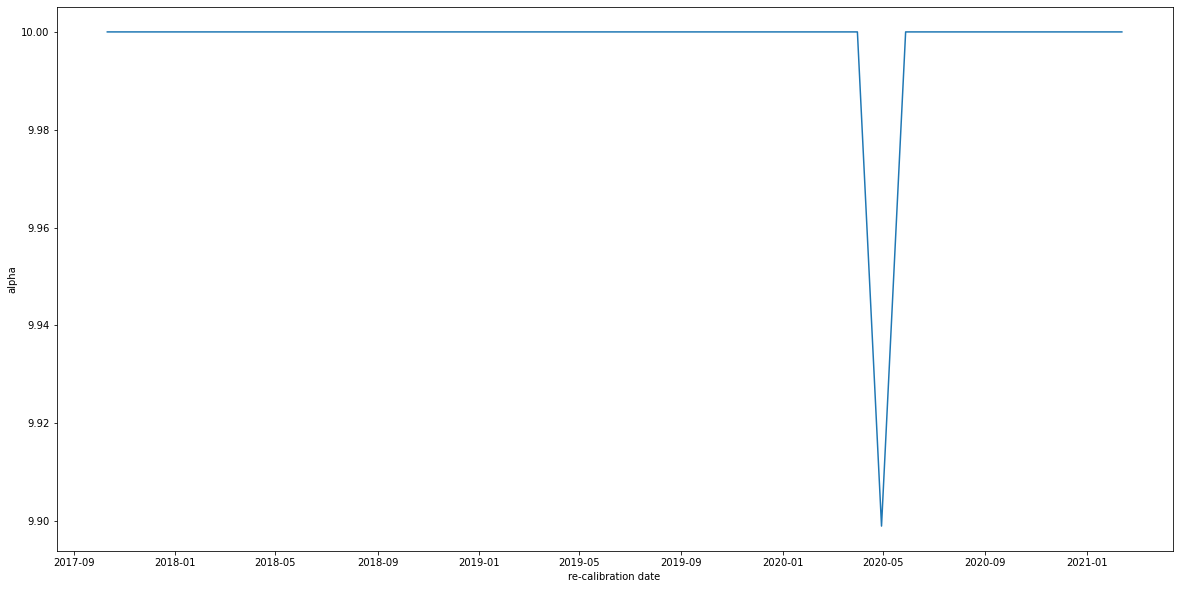

In [25]:
alpha=log[log.model=='ridge'].best_params.apply(lambda x : x['alpha']).values
calibration_date=log.period.unique()
plt.plot(calibration_date,alpha) 
plt.xlabel('re-calibration date')
plt.ylabel('alpha')
plt.show()

The selected alpha value for regularization was almost all the time equal to 10.

### 4. Elastic Net

The strategy resulted from the EN model has yielded a cumulative return and sharpe ratio higher than the long only strategy and has clearly outperformed the first strategy in the part of the backtesting period (after the covid crisis). It has however a lower SR and cumulative return than Ridge regression.

The EN model is a Linear Model trained with L2 and L1 priors as regularizers.

Elastic Net tries to get both aspects of Ridge and Lasso.

Here is the evolution of the each variable coefficient over the backtesting period and the evolution of the best l1-ratio (how much lasso regression is involved).

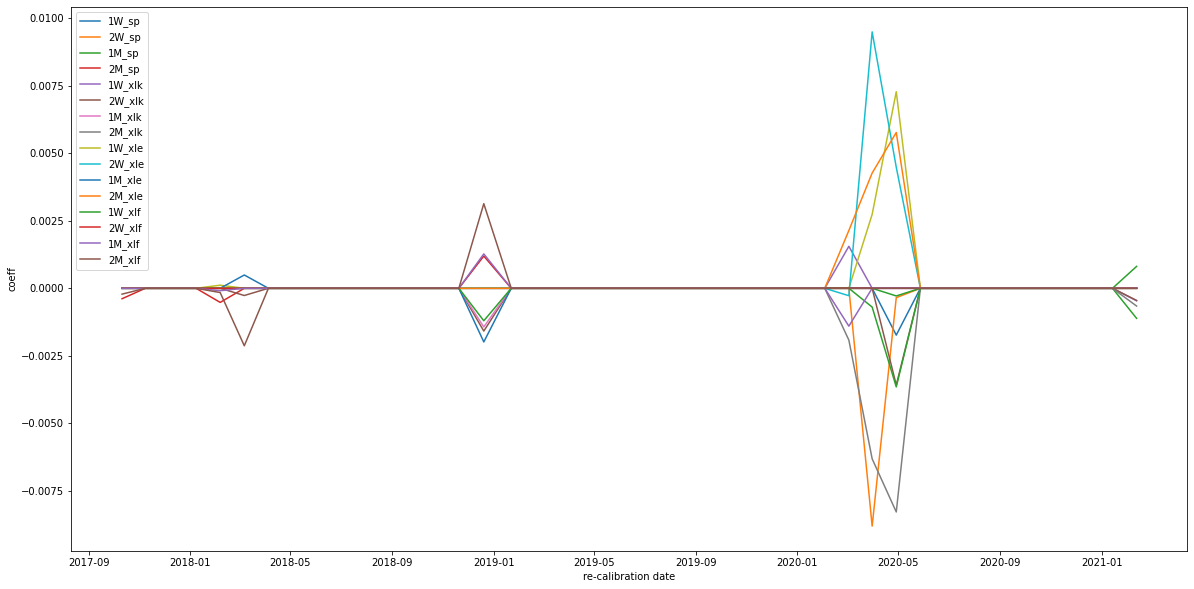

In [26]:
coef=np.concatenate(log[log.model=='EN'].coef.values,axis=0).reshape(43,16)
features=data.columns[:16]
calibration_date=log.period.unique()
for i in range(16): 
    plt.plot(calibration_date,coef[:,i],label=features[i])  
plt.legend()
plt.xlabel('re-calibration date')
plt.ylabel('coeff')
plt.show()

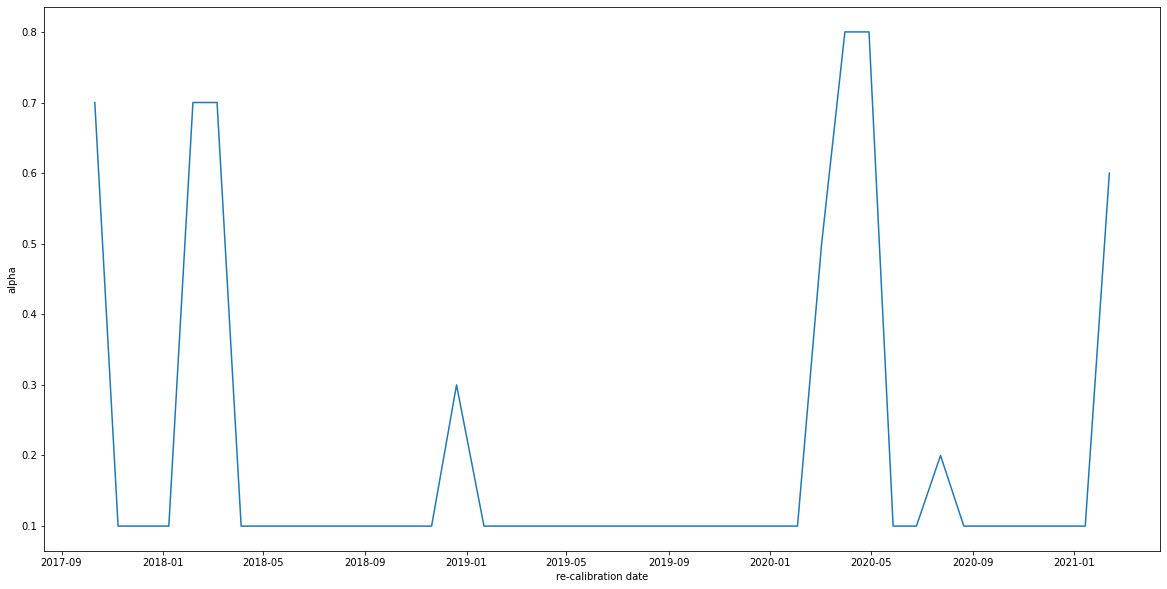

In [27]:
alpha=log[log.model=='EN'].best_params.apply(lambda x : x['l1_ratio']).values
calibration_date=log.period.unique()
plt.plot(calibration_date,alpha)  
plt.xlabel('re-calibration date')
plt.ylabel('alpha')
plt.show()

The selected l1 ratio varies between 0.1 and 0.8. In most cases, l1 prior was not overly present and the l2 prior was overly presented (exepct some recalibration periods)

### 5. kNN

The strategy resulted from the kNN model has yielded a cumulative return and sharpe ratio lower than the long only strategy and has clearly underperfomed even the risk free asset with negative SR and returns.

Here is the evolution the selectd number of neighbors for every recalibration period

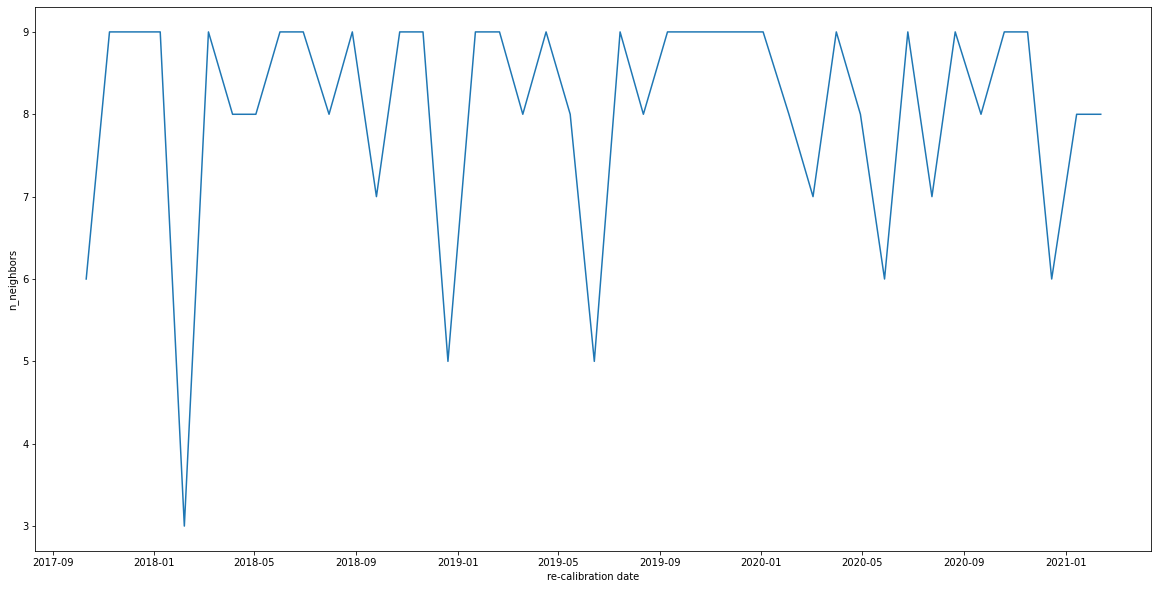

In [28]:
n_neighbors=log[log.model=='kNN'].best_params.apply(lambda x : x['n_neighbors']).values
calibration_date=log.period.unique()
plt.plot(calibration_date,n_neighbors)  
plt.xlabel('re-calibration date')
plt.ylabel('n_neighbors')
plt.show()

In [29]:
n_neighbors.mean()

8.069767441860465

The average number of neighbors selcted is 8.
KNN regression is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.
In the case of financial markets, local associations are not present and the kNN tends to yield bad results.